In [ ]:
import re
import json
import requests
from typing import Dict, Optional, Literal
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
BASE_URL = "https://eco-display-map.eco-counter.com"
# &startDate=2025-01-01&endDate=2025-11-30
site_id_cagnes_littoral = "300037212"  # Cagnes sur Mer (FR)

# Map pandas-style frequencies to ISO 8601 durations
FREQ_TO_GRANULARITY = {
    "D": "P1D",    # Day
    "W": "P1W",    # Week  
    "M": "P1M",    # Month
    "Y": "P1Y",    # Year
}

In [ ]:

# === HELPER FUNCTIONS ===

def build_url(
        site_id,
        granularity='D',
        start=None,
        end=None,
        ):
    """
    Build the URL for a specific site and time granularity.
    
    Parameters
    ----------
    site_id: str or int
        The counting site identifier
    granularity: str
        ISO 8601 duration (P1D, P1W, P1M, P1Y)
    start: str, optional
        Start date in 'YYYY-MM-DD' format
    end: str, optional
        End date in 'YYYY-MM-DD' format
        
    Returns
    -------
    str : 
        Complete URL to fetch data from.
        
    Examples
    --------
    >>> build_url("300037212", "P1Y")
    'https://eco-display-map.eco-counter.com/site/300037212?granularity=P1Y'
    """
    url = f"{BASE_URL}/site/{site_id}?granularity={granularity}"
    if start:
        url += f"&startDate={start}"
    if end:
        url += f"&endDate={end}"
    return url


def fetch_html(url: str) -> str:
    """
    Fetch the HTML content from a URL.
    
    Parameters
    ----------
    url: The URL to fetch
        
    Returns
    -------
    str: HTML content as string
        
    Raises
    ------
    requests.RequestException: If the request fails
        
    Examples
    --------
    >>> html = fetch_html("https://eco-display-map.eco-counter.com/site/300037212")
    >>> print(len(html))
    500000  # approximate

    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }
    response = requests.get(url, headers=headers, timeout=30)
    response.raise_for_status()  # Raise error if request failed
    return response.text

In [68]:
from bs4 import BeautifulSoup

def extract_nextjs_data(html: str) -> Optional[Dict]:
    """
    Extract Next.js embedded data using BeautifulSoup and json.loads.
    
    This is more robust than regex-based parsing.
    
    Parameters
    ----------
    html : str
        The HTML content
        
    Returns
    -------
    dict or None
        The extracted data dictionary
    """
    soup = BeautifulSoup(html, 'html.parser')
    # Find all script tags
    for script in soup.find_all('script'):
        script_content = script.string
        if not script_content:
            continue
        # Look for the __next_f.push pattern
        if 'self.__next_f.push' in script_content and 'chartData' in script_content:
            # Extract the data between the push() call
            # Pattern: self.__next_f.push([1,"..."])
            match = re.search(r'self\.__next_f\.push\(\[1,"(.+?)"\]\)', script_content, re.DOTALL)
            if match:
                # Get the escaped JSON string
                escaped_json = match.group(1)
                # Unescape it
                # Replace \\" with " and \\\\ with \\
                unescaped = escaped_json.replace('\\\\', '\x00')  # Temporary placeholder
                unescaped = unescaped.replace('\\"', '"')
                unescaped = unescaped.replace('\x00', '\\')  # Restore backslashes
                # Find the JSON object containing chartData
                # Look for the pattern: {"params":... ,"chartData":[...], ...}
                # We need to extract from the first { to its matching }
                # Find where chartData object starts
                chart_start = unescaped.find('"chartData"')
                if chart_start == -1:
                    continue
                # Go backwards to find the opening brace of the parent object
                brace_pos = chart_start
                while brace_pos > 0:
                    if unescaped[brace_pos] == '{':
                        # Check if this is the right level
                        # by counting if it contains the key structure we expect
                        break
                    brace_pos -= 1
                # Now find the matching closing brace
                brace_count = 0
                start_pos = brace_pos
                end_pos = start_pos
                for i in range(start_pos, len(unescaped)):
                    if unescaped[i] == '{':
                        brace_count += 1
                    elif unescaped[i] == '}':
                        brace_count -= 1
                        if brace_count == 0:
                            end_pos = i + 1
                            break
                # Extract the JSON substring
                json_str = unescaped[start_pos:end_pos]
                try:
                    # Parse with json.loads
                    data = json.loads(json_str)
                    # Verify we got the right data
                    if 'chartData' in data and 'kpi' in data:
                        return data
                except json.JSONDecodeError as e:
                    # If json.loads fails, the structure might have some issues
                    # Print debug info
                    print(f"JSON decode error: {e}")
                    print(f"Problematic JSON substring (first 200 chars): {json_str[:200]}")
                    continue
    return {}

In [139]:
def scrape_counts(
    start,
    end,
    freq="D",
    site_id = site_id_cagnes_littoral,
):
    """
    Scrape count data using simple HTTP requests (no browser needed!).
    
    This function:
    1. Builds the URL with the correct parameters
    2. Fetches the HTML with a simple HTTP GET
    3. Extracts the embedded JSON data using regex
    4. Returns structured data
    
    Parameters
    ---------
    start: pd.Timestamp or alike
        Beginning (included) of the requested period.
    end: pd.Timestamp or alike
        End of the requested period (excluded).
    freq: 
        Frequency/granularity ('D'=daily, 'W'=weekly, 'M'=monthly, 'Y'=yearly)
    site_id: int or str, optional
        Eco-Counter site identifier (default: Cagnes sur Mer)
        
    Returns
    -------
    dict :
        Dictionary containing metadata, KPIs, and time series data.
        
    Raises
    ------
    ValueError: If dates are invalid or frequency not supported
    requests.RequestException: If HTTP request fails
    
    """
    # Validate dates
    start_date = pd.Timestamp(start)
    end_date = pd.Timestamp(end)
    if start_date > end_date:
        raise ValueError(f"Start date ({start}) must be before end date ({end})")
    try:
        granularity = FREQ_TO_GRANULARITY[freq]
    except KeyError:
        raise ValueError(f"Unsupported frequency '{freq}'. Use one of {list(FREQ_TO_GRANULARITY.keys())}")
    # Build URL
    url = build_url(
        site_id, 
        granularity=granularity,
        start=start_date.date().isoformat(),
        end=end_date.date().isoformat(),
        )
    print(f"Fetching data from: {url}")
    # Fetch HTML
    html = fetch_html(url)
    print(f"Downloaded {len(html)} bytes")
    print("Extracting data...")
    result = extract_nextjs_data(html)
    return result

In [140]:
def extract_global_counts(fetched_data):
    """Return the traffic data for each period in a DataFrame

    Parameters
    ----------
    fetched_data : dict
        The data dictionary returned by scrape_counts()
    
    Returns
    -------
    pd.DataFrame
        The count of bicycles per period, without distinguishing direction.

    Notes
    -----
    The returned DataFrame has a DateTimeIndex and a single column 'count'.
    The data is fetched from the 'chartData' field in the fetched_data.
    """
    chart_data = fetched_data['chartData'][0]['data']
    data_table = _counts_as_df(chart_data)
    return data_table

def _counts_as_df(data_field):
    """Return a dataframf from the data field of counts.

    Parameters
    ----------
    data_field : list of dict
        The 'data' field from either global or directional counts.
        The data is a list of dicts with 'timestamp' and 'traffic' keys,
        where the counts are under traffic['counts'].

    Returns
    -------
    pd.DataFrame
        DataFrame with DateTimeIndex and a single 'count' column.
    """
    data_table = pd.DataFrame(
        [(pd.Timestamp(entry['timestamp']), entry['traffic']['counts']) for entry in data_field],
        columns=['timestamp', 'count'],
    )
    return data_table.set_index('timestamp')

def extract_directional_counts(fetched_data):
    """Return the directional traffic data for each period in a DataFrame

    Parameters
    ----------
    fetched_data : dict
        The data dictionary returned by scrape_counts()
    
    Returns
    -------
    pd.DataFrame
        The count of bicycles per period, with separate columns for each direction.

    Notes
    -----
    The returned DataFrame has a DateTimeIndex and two columns: 'in' and 'out'.
    The data is fetched from the 'directionGraphData' field in the fetched_data.
    """
    dir_data = []
    for direction_data in fetched_data['directionGraphData']:
        dir_name = direction_data['direction']
        dir_data.append(_counts_as_df(direction_data['data']))
        dir_data[-1].rename(columns={'count': dir_name}, inplace=True)
    # join on timestamp
    data_table = dir_data[0]
    for df in dir_data[1:]:
        data_table = data_table.join(df, how='outer')
    return data_table



In [141]:
example_result = scrape_counts(
    start='2021-01-01',
    end='2021-12-31',
    freq='D',
    )

Fetching data from: https://eco-display-map.eco-counter.com/site/300037212?granularity=P1D&startDate=2021-01-01&endDate=2021-12-31
Downloaded 635900 bytes
Extracting data...


In [146]:
example_result = scrape_counts(
    start='2022-01-01',
    end='2022-01-02',
    freq='D',
    )

Fetching data from: https://eco-display-map.eco-counter.com/site/300037212?granularity=P1D&startDate=2022-01-01&endDate=2022-01-02
Downloaded 578677 bytes
Extracting data...


In [147]:
example_result

{'params': '$@1c',
 'searchParams': '$@1b',
 'publicPage': '$7:0:props:publicPage',
 'currentSite': '$7:0:props:currentSite',
 'chartData': [{'travelMode': 'bike',
   'data': [{'timestamp': '2022-01-01T00:00:00+01:00',
     'traffic': {'counts': 1284}},
    {'timestamp': '2022-01-02T00:00:00+01:00', 'traffic': {'counts': 1812}}]}],
 'weatherData': [{'data': [{'timestamp': '2022-01-01T00:00:00+01:00',
     'traffic': {'counts': 1284}},
    {'timestamp': '2022-01-02T00:00:00+01:00', 'traffic': {'counts': 1812}}]}],
 'directionGraphData': [{'direction': 'in',
   'data': [{'timestamp': '2022-01-01T00:00:00+01:00',
     'traffic': {'counts': 670}},
    {'timestamp': '2022-01-02T00:00:00+01:00', 'traffic': {'counts': 918}}],
   'directionName': 'Vers Saint Laurent du Var'},
  {'direction': 'out',
   'data': [{'timestamp': '2022-01-01T00:00:00+01:00',
     'traffic': {'counts': 614}},
    {'timestamp': '2022-01-02T00:00:00+01:00', 'traffic': {'counts': 894}}],
   'directionName': 'Vers Villen

In [112]:
example_result['directionGraphData'][1]

{'direction': 'out',
 'data': [{'timestamp': '2021-06-14T00:00:00+02:00',
   'traffic': {'counts': 209}},
  {'timestamp': '2021-06-15T00:00:00+02:00', 'traffic': {'counts': 1185}},
  {'timestamp': '2021-06-16T00:00:00+02:00', 'traffic': {'counts': 1251}},
  {'timestamp': '2021-06-17T00:00:00+02:00', 'traffic': {'counts': 1202}},
  {'timestamp': '2021-06-18T00:00:00+02:00', 'traffic': {'counts': 1077}},
  {'timestamp': '2021-06-19T00:00:00+02:00', 'traffic': {'counts': 1128}},
  {'timestamp': '2021-06-20T00:00:00+02:00', 'traffic': {'counts': 1090}},
  {'timestamp': '2021-06-21T00:00:00+02:00', 'traffic': {'counts': 1235}},
  {'timestamp': '2021-06-22T00:00:00+02:00', 'traffic': {'counts': 1331}},
  {'timestamp': '2021-06-23T00:00:00+02:00', 'traffic': {'counts': 1228}},
  {'timestamp': '2021-06-24T00:00:00+02:00', 'traffic': {'counts': 1149}},
  {'timestamp': '2021-06-25T00:00:00+02:00', 'traffic': {'counts': 1212}},
  {'timestamp': '2021-06-26T00:00:00+02:00', 'traffic': {'counts': 12

In [113]:
extract_global_counts(example_result)

,count
timestamp,
2021-06-14 00:00:00+02:00,414
2021-06-15 00:00:00+02:00,2401
2021-06-16 00:00:00+02:00,2538
2021-06-17 00:00:00+02:00,2402
2021-06-18 00:00:00+02:00,2188
...,...
2021-12-27 00:00:00+01:00,449
2021-12-28 00:00:00+01:00,1941
2021-12-29 00:00:00+01:00,2458


In [116]:
extract_directional_counts(example_result)

,in,out
timestamp,,
2021-06-14 00:00:00+02:00,205,209
2021-06-15 00:00:00+02:00,1216,1185
2021-06-16 00:00:00+02:00,1287,1251
2021-06-17 00:00:00+02:00,1200,1202
2021-06-18 00:00:00+02:00,1111,1077
...,...,...
2021-12-27 00:00:00+01:00,238,211
2021-12-28 00:00:00+01:00,1012,929
2021-12-29 00:00:00+01:00,1240,1218


In [117]:
cagnes_data = []
for k in range(0,5):
    start = pd.Timestamp('2021-01-01') + pd.DateOffset(years=k)
    end = start + pd.DateOffset(years=1) - pd.DateOffset(days=1)
    new_result = scrape_counts(
        start=start,
        end=end,
        freq='D',
    )
    cagnes_data.append(
        extract_global_counts(new_result).join(extract_directional_counts(new_result), how='outer')
    )

Fetching data from: https://eco-display-map.eco-counter.com/site/300037212?granularity=P1D&startDate=2021-01-01&endDate=2021-12-31
Downloaded 635900 bytes
Extracting data...
Fetching data from: https://eco-display-map.eco-counter.com/site/300037212?granularity=P1D&startDate=2022-01-01&endDate=2022-12-31
Downloaded 679491 bytes
Extracting data...
Fetching data from: https://eco-display-map.eco-counter.com/site/300037212?granularity=P1D&startDate=2023-01-01&endDate=2023-12-31
Downloaded 688351 bytes
Extracting data...
Fetching data from: https://eco-display-map.eco-counter.com/site/300037212?granularity=P1D&startDate=2024-01-01&endDate=2024-12-31
Downloaded 674986 bytes
Extracting data...
Fetching data from: https://eco-display-map.eco-counter.com/site/300037212?granularity=P1D&startDate=2025-01-01&endDate=2025-12-31
Downloaded 679649 bytes
Extracting data...


In [118]:
cagnes_data_all = pd.concat(cagnes_data)

Text(0.5, 0, 'Date')

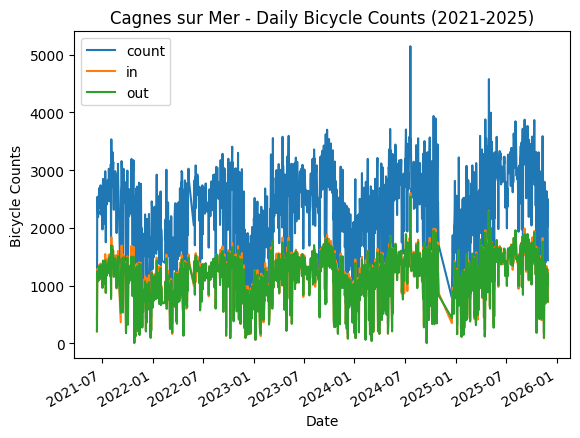

In [119]:
cagnes_data_all.plot(title="Cagnes sur Mer - Daily Bicycle Counts (2021-2025)")
plt.ylabel("Bicycle Counts")
plt.xlabel("Date")

<Axes: xlabel='timestamp'>

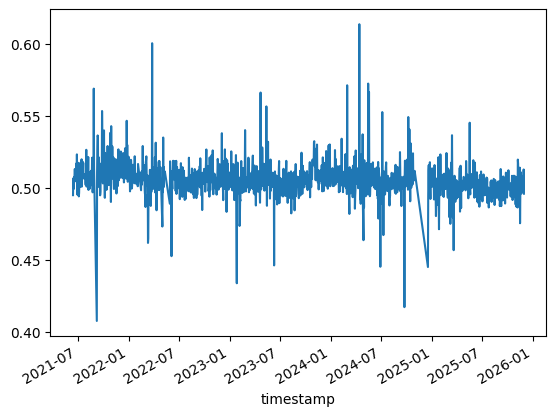

In [131]:
(cagnes_data_all.loc[:,'in'] / cagnes_data_all.loc[:,'count']).plot()